Restarted lalor0 (Python 3.11.4)

In [1]:
# setup
# bash script vars
# 
###########################################################################################
if "subj_num" in os.environ: 
    subj_num=os.environ["subj_num"]
    which_stmps=os.environ["which_stmps"] #xcorr or evnt
    which_xcorr=os.environ["which_xcorr"]
    bool_dict={"true":True,"false":False}
    just_stmp=bool_dict[os.environ["just_stmp"].lower()]
    print(f"just_stamp translated into: {just_stmp}")
#####################################################################################
#manual vars
#####################################################################################
else:
    print("using manually inputted vars")
    subj_num="3253"
    which_stmps="xcorr"
    script_name="preprocess_segment"
    which_xcorr="wavs"
    just_stmp=False
    # noisy_or_clean="clean" #NOTE: clean is default and setting them here does nothing
##################################################################################
confidence_lims=[0.80, 0.40]
#print max, min pearsonr correlation thresholds
print(f'minimum pearsonr threshold: {min(confidence_lims)}')
timestamps_bad=False #we trust the stamps now, but there may be a bug in sementation
# determine filter params applied to EEG before segmentation 
# NOTE: different from filter lims used in timestamp detection algo (!)
filt_band_lims=[1.0, 15] #Hz; highpass, lowpass cutoffs
filt_o=3 # order of filter (effective order x2 of this since using zero-phase)
processed_dir_path=os.path.join(eeg_dir, f"preprocessed_{which_stmps}") #directory where processed data goes
subj_cat=utils.get_subj_cat(subj_num) #note: checked get_subj_cat, should be fine
raw_dir=os.path.join(eeg_dir, "raw")
print(f"Fetching data for {subj_num, subj_cat}")
subj_eeg=utils.get_full_raw_eeg(raw_dir, subj_cat, subj_num, blocks=blocks)

NameError: name 'os' is not defined

In [ ]:
# find timestamps
if which_stmps=="xcorr":
    # Find timestamps using xcorr algo
    # check if save directory exists, else make one
    save_path=os.path.join(processed_dir_path,subj_cat,subj_num)
    if not os.path.isdir(save_path):
        print(f"preprocessed dir for {subj_num, subj_cat} not found, creating one.")
        os.makedirs(save_path, exist_ok=True)
    # check if timestamps fl exists already
    timestamps_path = os.path.join("..","eeg_data","timestamps",subj_cat,subj_num,
                                f"{which_xcorr}_timestamps.pkl")
    if os.path.exists(timestamps_path) and not timestamps_bad:
        # if already have timestamps, load from pkl:
        print(f"{subj_num, subj_cat} already has timestamps, loading from pkl.")
        with open(timestamps_path, 'rb') as pkl_fl: 
            timestamps = pickle.load(pkl_fl)
    else:
        print(f"Generating timestamps for {subj_num, subj_cat} ...")
        # get timestamps
        timestamps=utils.get_timestamps(subj_eeg,raw_dir,subj_num,
                                        subj_cat,stims_dict,blocks,which_xcorr,
                                        confidence_lims)
        # check resulting times
        total_soundtime=0
        missing_stims_list=[]
        for block in timestamps:
            block_sound_time=0
            for stim_nm, (start, end, confidence) in timestamps[block].items():
                if all([start,end,confidence]):
                    block_sound_time+=(end-start-1)/fs_eeg
                else:
                    missing_stims_list.append(stim_nm)
            print(f"in block {block}, total sound time is {block_sound_time:.3f} s.")
            total_soundtime+=block_sound_time
        print(f"total sound time: {total_soundtime:.3f} s.")
        print(f"missing stims:\n{len(missing_stims_list)}")
        #  save stim timestamps
        with open(timestamps_path, 'wb') as f:
            print(f"saving timestamps for {subj_num}")
            pickle.dump(timestamps, f)
if which_stmps=="evnt":
    # load evnt timestamps
    #TODO: make evnt timestamps loading function a util
    # check if save directory exists, else make one
    save_path = os.path.join(processed_dir_path, subj_cat, subj_num)
    if not os.path.isdir(save_path):
        print(f"preprocessed dir for {subj_num, subj_cat} not found, creating one.")
        os.makedirs(save_path, exist_ok=True)
    # find evnt timestamps
    timestamps_path=os.path.join("..","eeg_data","timestamps",f"evnt_{subj_num}.mat")
    evnt_mat=spio.loadmat(timestamps_path)
    # returns dict for some reason, which mat2dict doesnt like
    evnt=evnt_mat['evnt']
    evnt=utils.mat2dict(evnt)

: 

In [2]:
# imports, etc.
import pickle
import scipy.io as spio
import numpy as np

import os
# import sounddevice as sd # note not available via conda....? not sure I'll need anyway so ignore for now
from scipy import signal
import matplotlib.pyplot as plt
import utils

# specify fl paths assumes running from code as pwd
eeg_dir=os.path.join("..", "eeg_data")
# stim_fnm = "master_stim_file_schiz_studybis.mat" # note this is original fnm from box, we changed to just stim_info.mat
stim_fnm="stim_info.mat"
stim_fl_path=os.path.join(eeg_dir, "stim_info.mat")
stims_dict=utils.get_stims_dict(stim_fl_path)
fs_audio=stims_dict['fs'][0] # 11025 foriginally
# fs_audio=16000 #just trying it out cuz nothing else works
fs_eeg=2400 #trie d2kHz didn't help
fs_trf=100 # Hz, downsampling frequency for trf analysis
n_blocks = 6
blocks = [f"B{ii}" for ii in range(1, n_blocks+1)]#NOTE: this is kinda unnecesary and I wanna remove it but focusing on bigger problem rn

In [3]:
# setup
# bash script vars
# 
###########################################################################################
if "subj_num" in os.environ: 
    subj_num=os.environ["subj_num"]
    which_stmps=os.environ["which_stmps"] #xcorr or evnt
    which_xcorr=os.environ["which_xcorr"]
    bool_dict={"true":True,"false":False}
    just_stmp=bool_dict[os.environ["just_stmp"].lower()]
    print(f"just_stamp translated into: {just_stmp}")
#####################################################################################
#manual vars
#####################################################################################
else:
    print("using manually inputted vars")
    subj_num="3253"
    which_stmps="xcorr"
    script_name="preprocess_segment"
    which_xcorr="wavs"
    just_stmp=False
    # noisy_or_clean="clean" #NOTE: clean is default and setting them here does nothing
##################################################################################
confidence_lims=[0.80, 0.40]
#print max, min pearsonr correlation thresholds
print(f'minimum pearsonr threshold: {min(confidence_lims)}')
timestamps_bad=False #we trust the stamps now, but there may be a bug in sementation
# determine filter params applied to EEG before segmentation 
# NOTE: different from filter lims used in timestamp detection algo (!)
filt_band_lims=[1.0, 15] #Hz; highpass, lowpass cutoffs
filt_o=3 # order of filter (effective order x2 of this since using zero-phase)
processed_dir_path=os.path.join(eeg_dir, f"preprocessed_{which_stmps}") #directory where processed data goes
subj_cat=utils.get_subj_cat(subj_num) #note: checked get_subj_cat, should be fine
raw_dir=os.path.join(eeg_dir, "raw")
print(f"Fetching data for {subj_num, subj_cat}")
subj_eeg=utils.get_full_raw_eeg(raw_dir, subj_cat, subj_num, blocks=blocks)

using manually inputted vars
minimum pearsonr threshold: 0.4
Fetching data for ('3253', 'hc')


In [4]:
# find timestamps
if which_stmps=="xcorr":
    # Find timestamps using xcorr algo
    # check if save directory exists, else make one
    save_path=os.path.join(processed_dir_path,subj_cat,subj_num)
    if not os.path.isdir(save_path):
        print(f"preprocessed dir for {subj_num, subj_cat} not found, creating one.")
        os.makedirs(save_path, exist_ok=True)
    # check if timestamps fl exists already
    timestamps_path = os.path.join("..","eeg_data","timestamps",subj_cat,subj_num,
                                f"{which_xcorr}_timestamps.pkl")
    if os.path.exists(timestamps_path) and not timestamps_bad:
        # if already have timestamps, load from pkl:
        print(f"{subj_num, subj_cat} already has timestamps, loading from pkl.")
        with open(timestamps_path, 'rb') as pkl_fl: 
            timestamps = pickle.load(pkl_fl)
    else:
        print(f"Generating timestamps for {subj_num, subj_cat} ...")
        # get timestamps
        timestamps=utils.get_timestamps(subj_eeg,raw_dir,subj_num,
                                        subj_cat,stims_dict,blocks,which_xcorr,
                                        confidence_lims)
        # check resulting times
        total_soundtime=0
        missing_stims_list=[]
        for block in timestamps:
            block_sound_time=0
            for stim_nm, (start, end, confidence) in timestamps[block].items():
                if all([start,end,confidence]):
                    block_sound_time+=(end-start-1)/fs_eeg
                else:
                    missing_stims_list.append(stim_nm)
            print(f"in block {block}, total sound time is {block_sound_time:.3f} s.")
            total_soundtime+=block_sound_time
        print(f"total sound time: {total_soundtime:.3f} s.")
        print(f"missing stims:\n{len(missing_stims_list)}")
        #  save stim timestamps
        with open(timestamps_path, 'wb') as f:
            print(f"saving timestamps for {subj_num}")
            pickle.dump(timestamps, f)
if which_stmps=="evnt":
    # load evnt timestamps
    #TODO: make evnt timestamps loading function a util
    # check if save directory exists, else make one
    save_path = os.path.join(processed_dir_path, subj_cat, subj_num)
    if not os.path.isdir(save_path):
        print(f"preprocessed dir for {subj_num, subj_cat} not found, creating one.")
        os.makedirs(save_path, exist_ok=True)
    # find evnt timestamps
    timestamps_path=os.path.join("..","eeg_data","timestamps",f"evnt_{subj_num}.mat")
    evnt_mat=spio.loadmat(timestamps_path)
    # returns dict for some reason, which mat2dict doesnt like
    evnt=evnt_mat['evnt']
    evnt=utils.mat2dict(evnt)

('3253', 'hc') already has timestamps, loading from pkl.


In [5]:
# preprocess each block separately
if not just_stmp:
    timestamps_ds = {}
    print(f"Starting preprocessing {subj_num, subj_cat}")
    for block, raw_eeg in subj_eeg.items():
        print(f"block: {block}")
        timestamps_ds[block] = {}
        # filter and resample
        if fs_eeg / 2 <= fs_trf:
            raise NotImplementedError("Nyquist") 
        sos=signal.butter(filt_o, filt_band_lims, btype='bandpass', output='sos', fs=fs_eeg)
        raw_eeg=signal.sosfiltfilt(sos, raw_eeg, axis=0)
        # get number of samples in downsampled waveform
        num_ds=int(np.floor((raw_eeg.shape[0]-1)*(fs_trf/fs_eeg)))
        # downsample eeg
        subj_eeg[block]=signal.resample(raw_eeg,num_ds,axis=0)
        # downsample timestamps
        for stim_nm, (start, end, confidence) in timestamps[block].items():
            if all([start,end,confidence]):
                
                s_ds = int(np.floor(start*(fs_trf/fs_eeg)))
                e_ds = int(np.floor(end*(fs_trf/fs_eeg))) #NOTE: off by one error maybe?
                timestamps_ds[block][stim_nm] = (s_ds, e_ds, confidence)
            else:
                timestamps_ds[block][stim_nm] = (None, None, confidence)
    #%
    # align downsampled eeg using ds timestamps
    print(f"Preprocessing done for {subj_num, subj_cat}. algining and segmenting eeg")
    subj_data = utils.align_responses(subj_eeg, timestamps_ds, stims_dict)
    subj_data['fs'] = fs_trf
    print("subj_data before pickling:")
    print(subj_data.head())
    print(f'saving to: {save_path}')
    subj_data.to_pickle(os.path.join(save_path, f"{which_xcorr}_aligned_resp.pkl"))
    print(f"{subj_num, subj_cat} preprocessing and segmentation complete.")
    # break

Starting preprocessing ('3253', 'hc')
block: B1
block: B2
block: B3
block: B4
block: B5
block: B6
Preprocessing done for ('3253', 'hc'). algining and segmenting eeg


TypeError: all() takes exactly one argument (2 given)

Restarted lalor0 (Python 3.11.4)

In [1]:
# imports, etc.
import pickle
import scipy.io as spio
import numpy as np

import os
# import sounddevice as sd # note not available via conda....? not sure I'll need anyway so ignore for now
from scipy import signal
import matplotlib.pyplot as plt
import utils

# specify fl paths assumes running from code as pwd
eeg_dir=os.path.join("..", "eeg_data")
# stim_fnm = "master_stim_file_schiz_studybis.mat" # note this is original fnm from box, we changed to just stim_info.mat
stim_fnm="stim_info.mat"
stim_fl_path=os.path.join(eeg_dir, "stim_info.mat")
stims_dict=utils.get_stims_dict(stim_fl_path)
fs_audio=stims_dict['fs'][0] # 11025 foriginally
# fs_audio=16000 #just trying it out cuz nothing else works
fs_eeg=2400 #trie d2kHz didn't help
fs_trf=100 # Hz, downsampling frequency for trf analysis
n_blocks = 6
blocks = [f"B{ii}" for ii in range(1, n_blocks+1)]#NOTE: this is kinda unnecesary and I wanna remove it but focusing on bigger problem rn

In [2]:
# setup
# bash script vars
# 
###########################################################################################
if "subj_num" in os.environ: 
    subj_num=os.environ["subj_num"]
    which_stmps=os.environ["which_stmps"] #xcorr or evnt
    which_xcorr=os.environ["which_xcorr"]
    bool_dict={"true":True,"false":False}
    just_stmp=bool_dict[os.environ["just_stmp"].lower()]
    print(f"just_stamp translated into: {just_stmp}")
#####################################################################################
#manual vars
#####################################################################################
else:
    print("using manually inputted vars")
    subj_num="3253"
    which_stmps="xcorr"
    script_name="preprocess_segment"
    which_xcorr="wavs"
    just_stmp=False
    # noisy_or_clean="clean" #NOTE: clean is default and setting them here does nothing
##################################################################################
confidence_lims=[0.80, 0.40]
#print max, min pearsonr correlation thresholds
print(f'minimum pearsonr threshold: {min(confidence_lims)}')
timestamps_bad=False #we trust the stamps now, but there may be a bug in sementation
# determine filter params applied to EEG before segmentation 
# NOTE: different from filter lims used in timestamp detection algo (!)
filt_band_lims=[1.0, 15] #Hz; highpass, lowpass cutoffs
filt_o=3 # order of filter (effective order x2 of this since using zero-phase)
processed_dir_path=os.path.join(eeg_dir, f"preprocessed_{which_stmps}") #directory where processed data goes
subj_cat=utils.get_subj_cat(subj_num) #note: checked get_subj_cat, should be fine
raw_dir=os.path.join(eeg_dir, "raw")
print(f"Fetching data for {subj_num, subj_cat}")
subj_eeg=utils.get_full_raw_eeg(raw_dir, subj_cat, subj_num, blocks=blocks)

using manually inputted vars
minimum pearsonr threshold: 0.4
Fetching data for ('3253', 'hc')


In [3]:
# find timestamps
if which_stmps=="xcorr":
    # Find timestamps using xcorr algo
    # check if save directory exists, else make one
    save_path=os.path.join(processed_dir_path,subj_cat,subj_num)
    if not os.path.isdir(save_path):
        print(f"preprocessed dir for {subj_num, subj_cat} not found, creating one.")
        os.makedirs(save_path, exist_ok=True)
    # check if timestamps fl exists already
    timestamps_path = os.path.join("..","eeg_data","timestamps",subj_cat,subj_num,
                                f"{which_xcorr}_timestamps.pkl")
    if os.path.exists(timestamps_path) and not timestamps_bad:
        # if already have timestamps, load from pkl:
        print(f"{subj_num, subj_cat} already has timestamps, loading from pkl.")
        with open(timestamps_path, 'rb') as pkl_fl: 
            timestamps = pickle.load(pkl_fl)
    else:
        print(f"Generating timestamps for {subj_num, subj_cat} ...")
        # get timestamps
        timestamps=utils.get_timestamps(subj_eeg,raw_dir,subj_num,
                                        subj_cat,stims_dict,blocks,which_xcorr,
                                        confidence_lims)
        # check resulting times
        total_soundtime=0
        missing_stims_list=[]
        for block in timestamps:
            block_sound_time=0
            for stim_nm, (start, end, confidence) in timestamps[block].items():
                if all([start,end,confidence]):
                    block_sound_time+=(end-start-1)/fs_eeg
                else:
                    missing_stims_list.append(stim_nm)
            print(f"in block {block}, total sound time is {block_sound_time:.3f} s.")
            total_soundtime+=block_sound_time
        print(f"total sound time: {total_soundtime:.3f} s.")
        print(f"missing stims:\n{len(missing_stims_list)}")
        #  save stim timestamps
        with open(timestamps_path, 'wb') as f:
            print(f"saving timestamps for {subj_num}")
            pickle.dump(timestamps, f)
if which_stmps=="evnt":
    # load evnt timestamps
    #TODO: make evnt timestamps loading function a util
    # check if save directory exists, else make one
    save_path = os.path.join(processed_dir_path, subj_cat, subj_num)
    if not os.path.isdir(save_path):
        print(f"preprocessed dir for {subj_num, subj_cat} not found, creating one.")
        os.makedirs(save_path, exist_ok=True)
    # find evnt timestamps
    timestamps_path=os.path.join("..","eeg_data","timestamps",f"evnt_{subj_num}.mat")
    evnt_mat=spio.loadmat(timestamps_path)
    # returns dict for some reason, which mat2dict doesnt like
    evnt=evnt_mat['evnt']
    evnt=utils.mat2dict(evnt)

('3253', 'hc') already has timestamps, loading from pkl.


Starting preprocessing ('3253', 'hc')
block: B1
block: B2
block: B3
block: B4
block: B5
block: B6
Preprocessing done for ('3253', 'hc'). algining and segmenting eeg
Help on function get_stim_wav in module utils:

get_stim_wav(stims_dict, stim_nm: str, noisy_or_clean='clean')



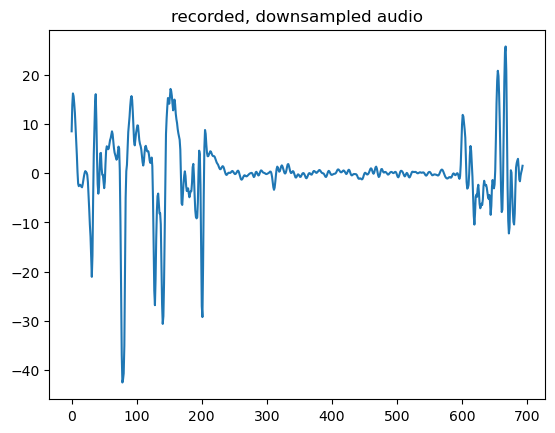

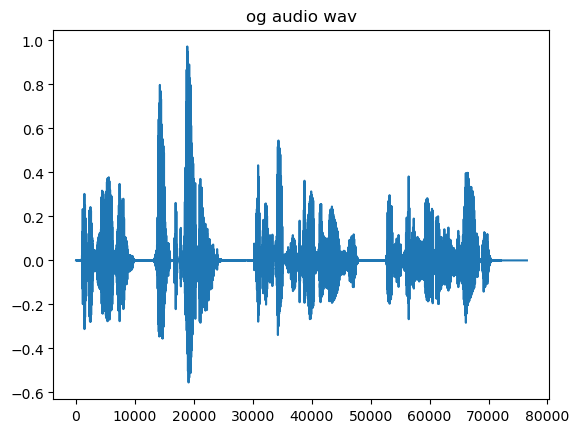

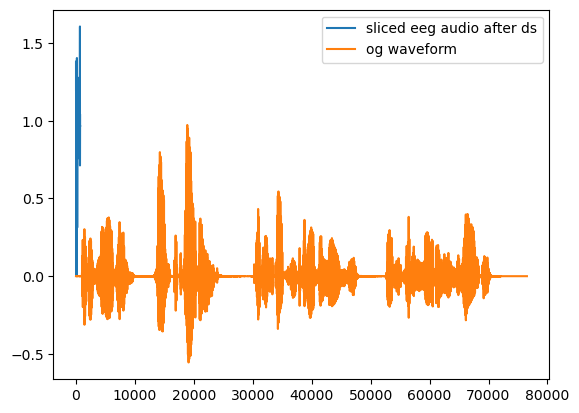

Help on built-in function arange in module numpy:

arange(...)
    arange([start,] stop[, step,], dtype=None, *, like=None)
    
    Return evenly spaced values within a given interval.
    
    ``arange`` can be called with a varying number of positional arguments:
    
    * ``arange(stop)``: Values are generated within the half-open interval
      ``[0, stop)`` (in other words, the interval including `start` but
      excluding `stop`).
    * ``arange(start, stop)``: Values are generated within the half-open
      interval ``[start, stop)``.
    * ``arange(start, stop, step)`` Values are generated within the half-open
      interval ``[start, stop)``, with spacing between values given by
      ``step``.
    
    For integer arguments the function is roughly equivalent to the Python
    built-in :py:class:`range`, but returns an ndarray rather than a ``range``
    instance.
    
    When using a non-integer step, such as 0.1, it is often better to use
    `numpy.linspace`.
    
    S

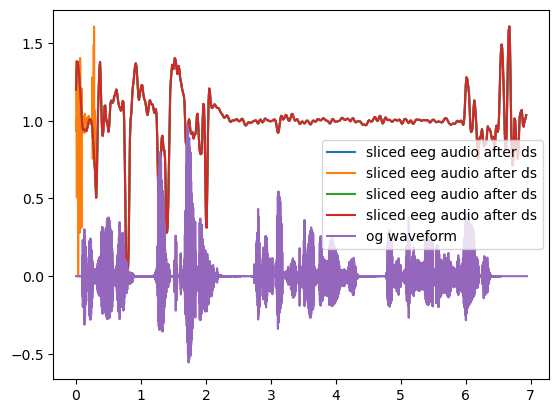

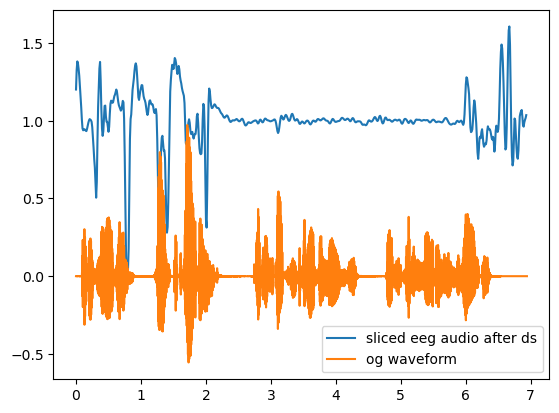

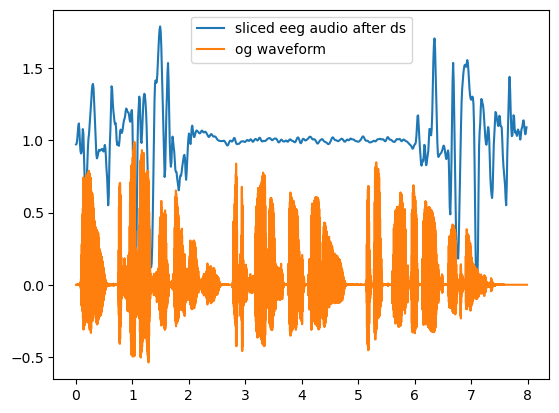

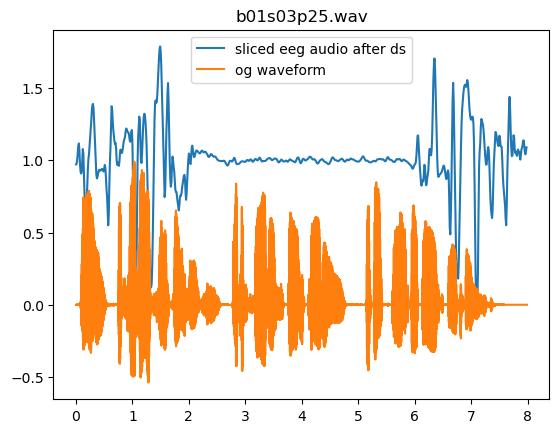

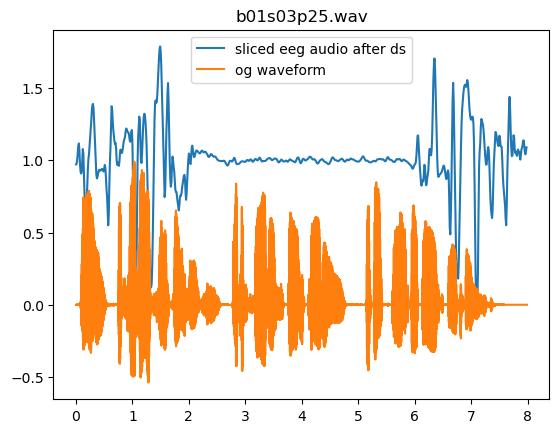

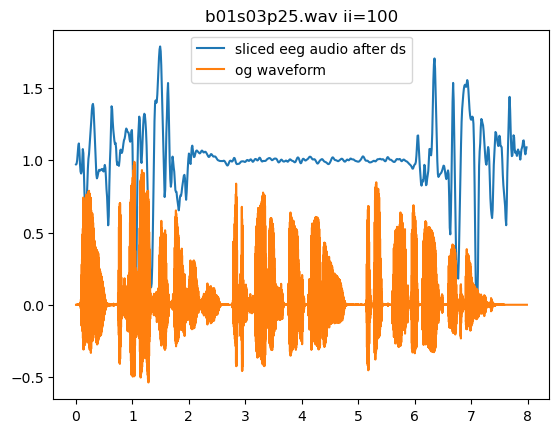

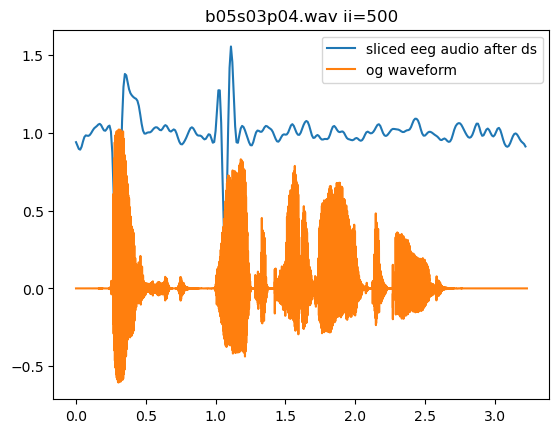

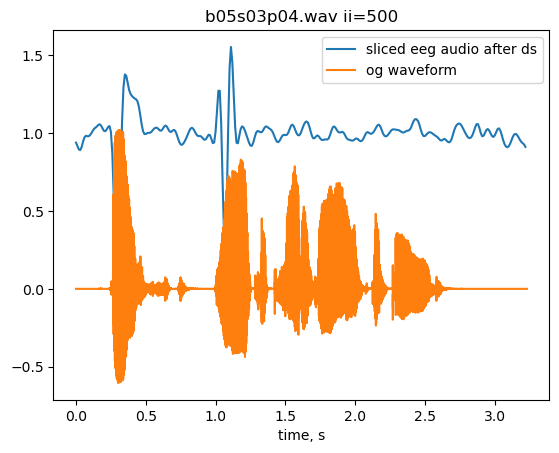

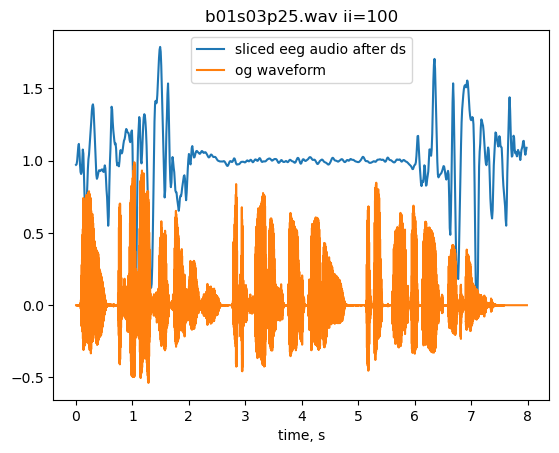

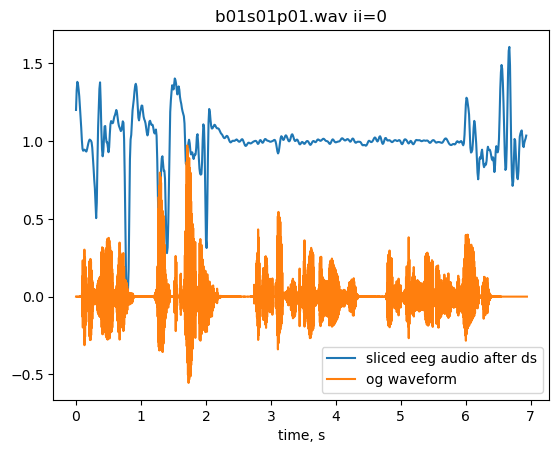

subj_data before pickling:
        stim_nms                                                eeg  \
0  b01s01p01.wav  [[5.0251064776519785, 4.497798893261498, 5.051...   
1  b01s01p02.wav  [[-26.13806650248973, -30.830208523142783, -31...   
2  b01s01p03.wav  [[10.129910854986923, 7.417262406208717, 8.263...   
3  b01s01p04.wav  [[76.32068407239596, 86.586250946196, 88.22821...   
4  b01s01p05.wav  [[-22.05121467306794, -22.85570634158595, -17....   

                                           eeg_audio  confidence   fs  
0  [8.52336640950624, 13.871651567535253, 16.2181...    0.538433  100  
1  [1.9890054283527634, 2.137689607576529, 1.9647...    0.448757  100  
2  [2.3566002800516537, 2.328281790020478, 1.9804...    0.568699  100  
3  [-2.497236818698821, -3.4350313901603022, -3.5...    0.507445  100  
4  [-6.5781376962507165, -3.608203428749547, 0.59...    0.461621  100  
saving to: ../eeg_data/preprocessed_xcorr/hc/3253
('3253', 'hc') preprocessing and segmentation complete.


In [4]:
# preprocess each block separately
if not just_stmp:
    timestamps_ds = {}
    print(f"Starting preprocessing {subj_num, subj_cat}")
    for block, raw_eeg in subj_eeg.items():
        print(f"block: {block}")
        timestamps_ds[block] = {}
        # filter and resample
        if fs_eeg / 2 <= fs_trf:
            raise NotImplementedError("Nyquist") 
        sos=signal.butter(filt_o, filt_band_lims, btype='bandpass', output='sos', fs=fs_eeg)
        raw_eeg=signal.sosfiltfilt(sos, raw_eeg, axis=0)
        # get number of samples in downsampled waveform
        num_ds=int(np.floor((raw_eeg.shape[0]-1)*(fs_trf/fs_eeg)))
        # downsample eeg
        subj_eeg[block]=signal.resample(raw_eeg,num_ds,axis=0)
        # downsample timestamps
        for stim_nm, (start, end, confidence) in timestamps[block].items():
            if all([start,end,confidence]):
                
                s_ds = int(np.floor(start*(fs_trf/fs_eeg)))
                e_ds = int(np.floor(end*(fs_trf/fs_eeg))) #NOTE: off by one error maybe?
                timestamps_ds[block][stim_nm] = (s_ds, e_ds, confidence)
            else:
                timestamps_ds[block][stim_nm] = (None, None, confidence)
    #%
    # align downsampled eeg using ds timestamps
    print(f"Preprocessing done for {subj_num, subj_cat}. algining and segmenting eeg")
    subj_data = utils.align_responses(subj_eeg, timestamps_ds, stims_dict)
    subj_data['fs'] = fs_trf
    print("subj_data before pickling:")
    print(subj_data.head())
    print(f'saving to: {save_path}')
    subj_data.to_pickle(os.path.join(save_path, f"{which_xcorr}_aligned_resp.pkl"))
    print(f"{subj_num, subj_cat} preprocessing and segmentation complete.")
    # break

In [5]:
type(timestamps_ds['B1'])


dict

In [6]:
dum1=np.array([0,1,2,3])
dum2=np.array([1,2,3,4])
np.all(dum2-dum1)>0

True

In [7]:
dum1=np.array([0,1,2,3])
dum2=np.array([1,2,3,4])
dum2-dum1>0

array([ True,  True,  True,  True])

In [8]:
dum1[1:]

array([1, 2, 3])

In [9]:
np.min(dum1,dum2)


KeyboardInterrupt



In [10]:
np.min?

Signature:      
np.min(
    a,
    axis=None,
    out=None,
    keepdims=<no value>,
    initial=<no value>,
    where=<no value>,
)
Call signature:  np.min(*args, **kwargs)
Type:            _ArrayFunctionDispatcher
String form:     <function min at 0x7f326806df80>
File:            /scratch/apalaci6/miniconda3/envs/lalor0/lib/python3.11/site-packages/numpy/core/fromnumeric.py
Docstring:      
Return the minimum of an array or minimum along an axis.

Parameters
----------
a : array_like
    Input data.
axis : None or int or tuple of ints, optional
    Axis or axes along which to operate.  By default, flattened input is
    used.

    .. versionadded:: 1.7.0

    If this is a tuple of ints, the minimum is selected over multiple axes,
    instead of a single axis or all the axes as before.
out : ndarray, optional
    Alternative output array in which to place the result.  Must
    be of the same shape and buffer length as the expected output.
    See :ref:`ufuncs-output-type` for more de

In [11]:
np.min([dum1,dum2])

0

In [12]:
!(dum1-dum2)>0

3673.98s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
/bin/bash: dum1-dum2: command not found


In [13]:
dum1

array([0, 1, 2, 3])

In [14]:
(dum1-dum2)!>0

SyntaxError: invalid syntax (<ipython-input-14-bafea8a993a2>, line 1)

In [15]:
timestamps

{'B1': {'b01s01p01.wav': (51545, 68203, 0.5384328969955099),
  'b01s01p02.wav': (68203, 85385, 0.44875740954159904),
  'b01s01p03.wav': (85385, 98901, 0.5686994708815158),
  'b01s01p04.wav': (98901, 115287, 0.5074445772205167),
  'b01s01p05.wav': (199936, 208525, 0.4616205392131261),
  'b01s01p06.wav': (208525, 221633, 0.506834284527553),
  'b01s01p07.wav': (None, None, 0.39380859379840405),
  'b01s01p08.wav': (230390, 239371, 0.5499151431123506),
  'b01s01p09.wav': (239371, 255728, 0.48351565706293903),
  'b01s01p10.wav': (None, None, 0.32333314176308514),
  'b01s01p11.wav': (266837, 278694, 0.48891758295562276),
  'b01s01p12.wav': (None, None, 0.39833418398139736),
  'b01s01p13.wav': (287969, 300279, 0.5086768894243925),
  'b01s01p14.wav': (300279, 309895, 0.5013940659956834),
  'b01s01p15.wav': (345679, 353214, 0.4887902521641949),
  'b01s01p16.wav': (353214, 359949, 0.6518111343062168),
  'b01s01p17.wav': (359949, 370856, 0.41948447133669486),
  'b01s01p18.wav': (None, None, 0.2614

In [16]:
def check_timestamps(timestamps):
    '''
    helper to make sure timestamps are non-overlapping and strictly ascending
    '''
    for block in timestamps:
        print(f"checking block {block}:\n")
        nms=[]
        starts=[]
        ends=[]
        for nm,(start,end,_) in timestamps[block].items():
            if all([start,end]):
                nms.append(nm)
                starts.append(start)
                ends.append(end)
        #convert to arrays for mathing
        starts=np.array(starts)
        ends=np.array(ends)
        #check non-overlapping:
        if np.all((starts[1:]-ends[:-1])>=0) and\
            starts[0]==np.min([starts,ends]) and\
            ends[-1]==np.max([starts,ends]):
            print("no indices overlap")
        else:
            n_overalapping=np.sum((starts[1:]-ends[:-1])<0)
            #note: ignoring start and end; this should trivially not overlap anyway
            print(f"{n_overalapping} indices overlap.")